In [1]:
import pandas as pd
final_df=pd.read_csv('../Dataset/final_df.csv')

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load geojson
gdf = gpd.read_file("../Dataset/GeoJSON/india_pincode.geojson")

In [4]:
bio_cols = [
    "bio_age_5_17",
    "bio_age_17_greater"
]

final_df[bio_cols] = (
    final_df[bio_cols]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
)

In [7]:
state_bio = (
    final_df
    .groupby("state", as_index=False)[bio_cols]
    .sum()
)

# 5-17 Biometric

In [9]:
top_5_17 = (
    state_bio
    .sort_values("bio_age_5_17", ascending=False)
    .head(5)
)
top_5_17

,state,bio_age_5_17,bio_age_17_greater
33,Uttar Pradesh,5711585.0,3133350.0
19,Madhya Pradesh,3143588.0,2642043.0
20,Maharashtra,3124631.0,5046758.0
4,Bihar,2181218.0,2661413.0
30,Tamil Nadu,1869916.0,2191247.0


In [10]:
india_states = gpd.read_file("../Dataset/GeoJSON/india_state_geo.json")

In [11]:
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

top_5_17["state_norm"] = (
    top_5_17["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

In [12]:
top_states_geo = india_states[
    india_states["state_norm"].isin(top_5_17["state_norm"])
]
top_states_geo[["NAME_1", "state_norm"]]



,NAME_1,state_norm
4,Bihar,bihar
19,Madhya Pradesh,madhya pradesh
20,Maharashtra,maharashtra
30,Tamil Nadu,tamil nadu
32,Uttar Pradesh,uttar pradesh


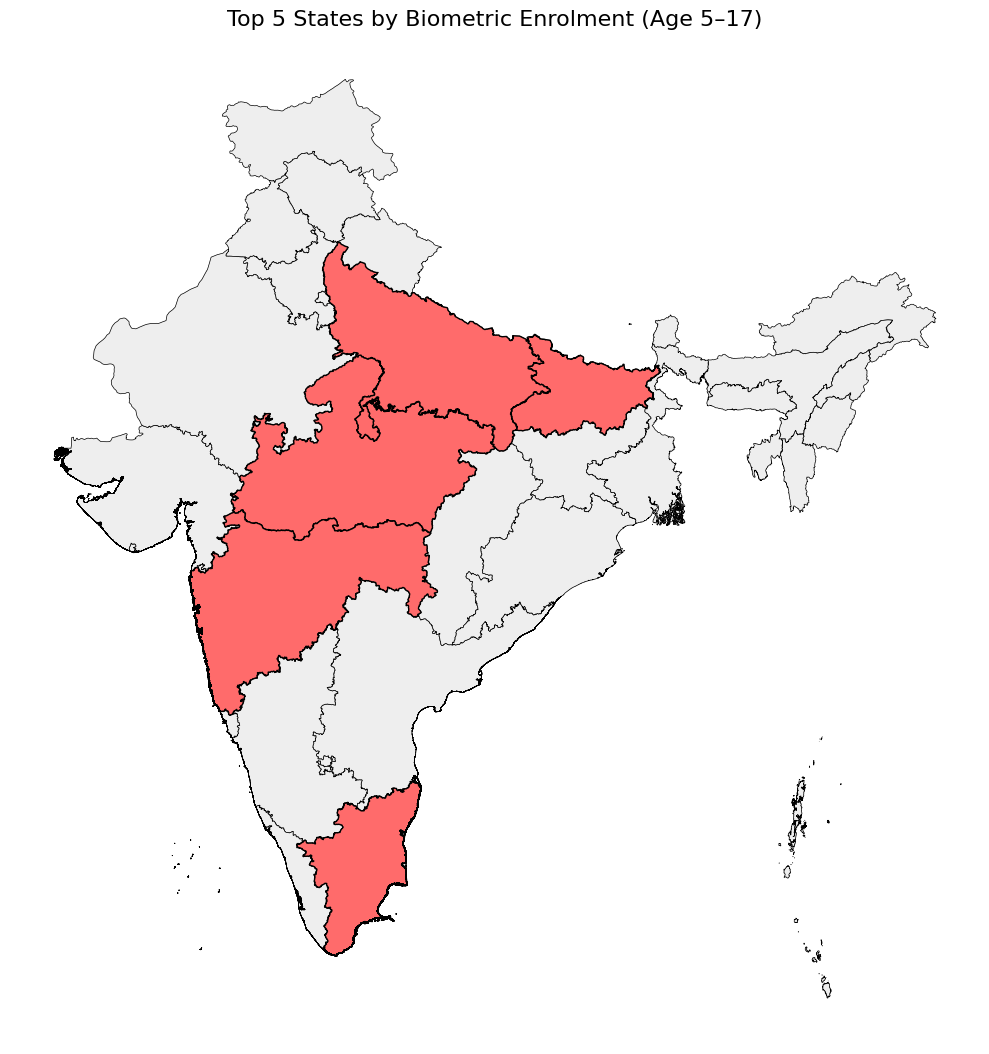

In [13]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all states in light grey
india_states.plot(
    ax=ax,
    color="#eeeeee",
    edgecolor="black",
    linewidth=0.5
)

# Highlight top 5 states
top_states_geo.plot(
    ax=ax,
    color="#ff6b6b",
    edgecolor="black",
    linewidth=1
)

ax.set_title("Top 5 States by Biometric Enrolment (Age 5–17)", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


# Uttar Pradesh Biometric Status 5-17

In [14]:
up_df = final_df[final_df["state"] == "Uttar Pradesh"].copy()


In [15]:
top_districts_5_17 = (
    up_df
    .groupby("district", as_index=False)["bio_age_5_17"]
    .sum()
    .sort_values("bio_age_5_17", ascending=False)
)

top_districts_5_17

,district,bio_age_5_17
70,Sitapur,201323.0
14,Bareilly,167304.0
0,Agra,153260.0
35,Hardoi,151099.0
1,Aligarh,144965.0
...,...,...
16,Bhadohi,3632.0
6,Ayodhya,3622.0
13,Barabanki,791.0
61,Raebareli,3.0


In [16]:
districts_gdf = gpd.read_file("../Dataset/GeoJSON/india_district.geojson")

In [17]:
districts_gdf["state_norm"] = (
    districts_gdf["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.strip()
)

up_districts_gdf = districts_gdf[
    districts_gdf["state_norm"] == "uttar pradesh"
].copy()


In [19]:
#District names normalization
def normalize_district(s):
    return (
        s.lower()
        .replace("&", "and")
        .replace(".", "")
        .replace(" district", "")
        .strip()
    )

up_districts_gdf["district_norm"] = (
    up_districts_gdf["NAME_2"].apply(normalize_district)
)

top_districts_5_17["district_norm"] = (
    top_districts_5_17["district"].apply(normalize_district)
)


In [49]:
gdf = up_districts_gdf.merge(
    top_districts_5_17,
    on="district_norm",
    how="left"
)

# Replace NaN enrolment with 0
gdf["bio_age_5_17"] = gdf["bio_age_5_17"].fillna(0)

In [50]:
top5 = (
    gdf[["NAME_2", "bio_age_5_17"]]
    .sort_values("bio_age_5_17", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

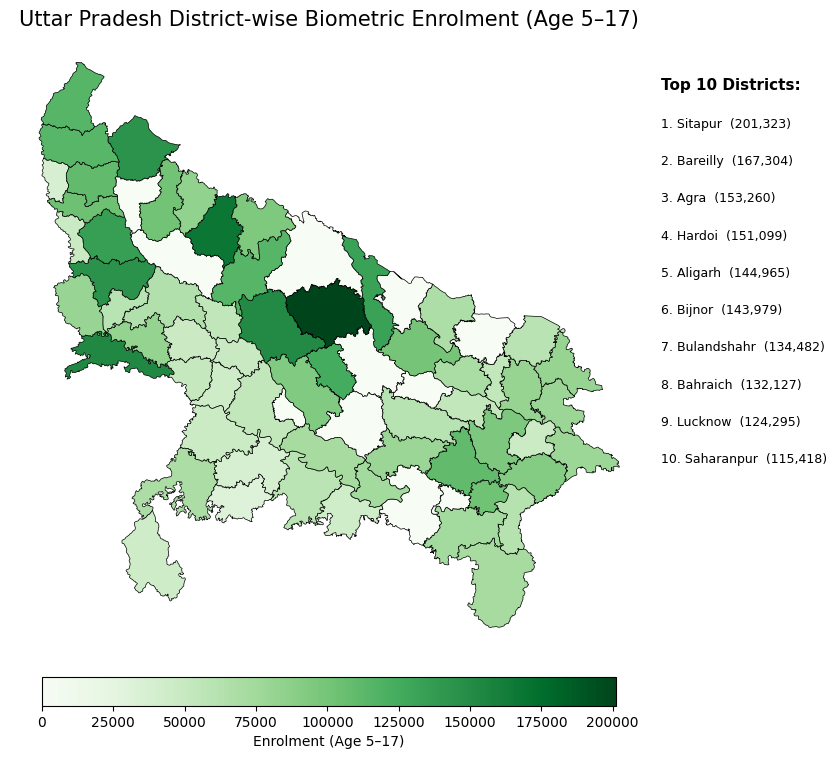

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

gdf.plot(
    ax=ax,
    column="bio_age_5_17",
    cmap="Greens",          # light → dark
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
    "label": "Enrolment (Age 5–17)",
    "orientation": "horizontal",
    "shrink": 0.9,
    "pad": 0.02
}
)

ax.set_title(
    "Uttar Pradesh District-wise Biometric Enrolment (Age 5–17)",
    fontsize=15
)
ax.axis("off")
x_pos = 1.02   # right of the map
y_start = 0.85
line_gap = 0.06

ax.text(
    x_pos, y_start + line_gap,
    "Top 10 Districts:",
    transform=ax.transAxes,
    fontsize=11,
    fontweight="bold",
    ha="left"
)

for i, row in top5.iterrows():
    ax.text(
        x_pos,
        y_start - i * line_gap,
        f"{i+1}. {row['NAME_2']}  ({int(row['bio_age_5_17']):,})",
        transform=ax.transAxes,
        fontsize=9,
        ha="left"
    )
plt.tight_layout(rect=[0, 0.08,0.85, 1])

plt.show()


In [27]:
sitapur_df = final_df[
    (final_df["state"] == "Uttar Pradesh") &
    (final_df["district"] == "Sitapur")
].copy()


In [28]:
import pandas as pd

sitapur_df["bio_age_5_17"] = pd.to_numeric(
    sitapur_df["bio_age_5_17"], errors="coerce"
).fillna(0)

pincode_enrol = (
    sitapur_df
    .groupby("pincode", as_index=False)["bio_age_5_17"]
    .sum()
)

# Ensure string for merge
pincode_enrol["pincode"] = pincode_enrol["pincode"].astype(str)

pincode_enrol


,pincode,bio_age_5_17
0,261001,16281.0
1,261121,9619.0
2,261125,2644.0
3,261131,6774.0
4,261135,15285.0
5,261136,6577.0
6,261141,10456.0
7,261145,3255.0
8,261151,4524.0
9,261201,19789.0


In [29]:
pin_code_gdf = gpd.read_file("../Dataset/GeoJSON/india_pincode.geojson")

In [30]:
# Ensure pincode column consistency
pin_code_gdf["Pincode"] = pin_code_gdf["Pincode"].astype(str).str.strip()

sitapur_gdf = pin_code_gdf.merge(
    pincode_enrol,
    left_on="Pincode",
    right_on="pincode",
    how="inner"
)


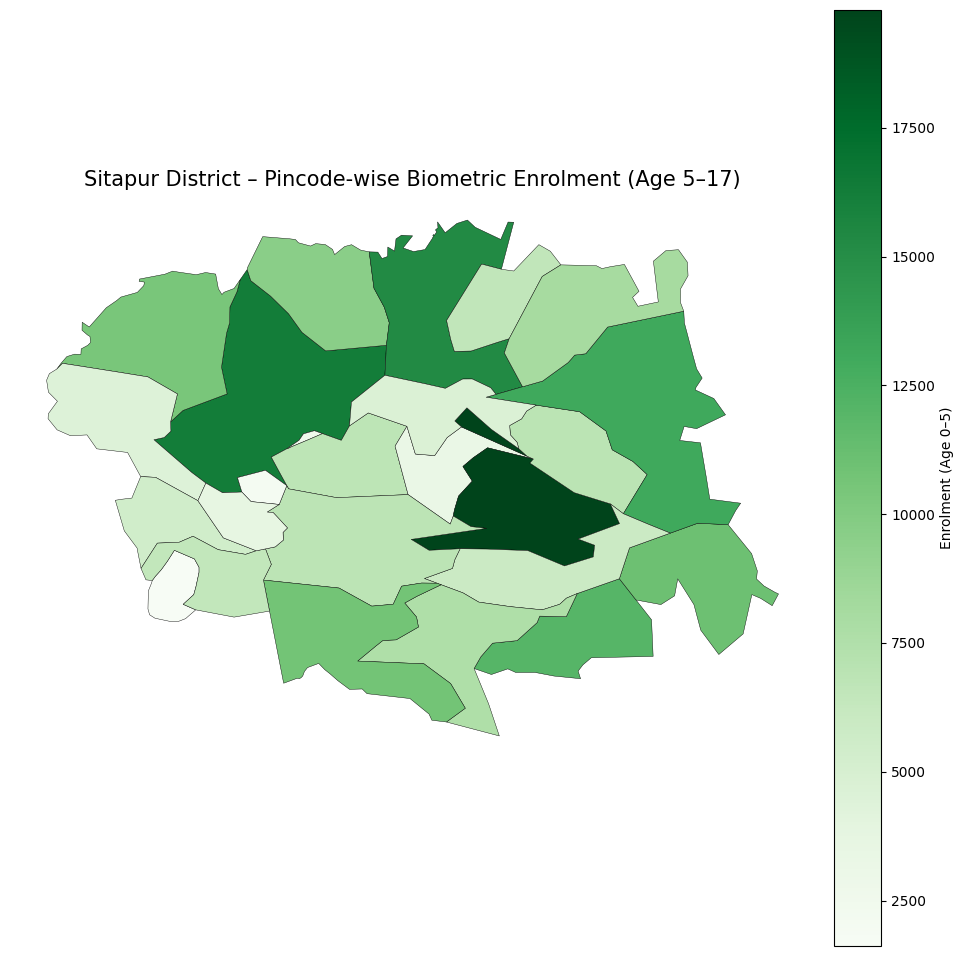

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

sitapur_gdf.plot(
    ax=ax,
    column="bio_age_5_17",
    cmap="Greens",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Enrolment (Age 0–5)",
        "shrink": 0.8,
        "pad": 0.02
    }
)

ax.set_title(
    "Sitapur District – Pincode-wise Biometric Enrolment (Age 5–17)",
    fontsize=15
)
ax.axis("off")

plt.tight_layout()
plt.show()


# 17+ Enrolment

In [34]:
top_18_ = (
    state_enrol
    .sort_values("bio_age_17_greater", ascending=False)
    .head(5)
)
top_18_

,state,bio_age_5_17,bio_age_17_greater
20,Maharashtra,3124631.0,5046758.0
33,Uttar Pradesh,5711585.0,3133350.0
4,Bihar,2181218.0,2661413.0
19,Madhya Pradesh,3143588.0,2642043.0
30,Tamil Nadu,1869916.0,2191247.0


In [36]:
india_states["state_norm"] = (
    india_states["NAME_1"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

top_18_["state_norm"] = (
    top_18_["state"]
    .str.lower()
    .str.replace("&", "and")
    .str.replace(" islands", "", regex=False)
    .str.strip()
)

In [37]:
top_states_geo_18_ = india_states[
    india_states["state_norm"].isin(top_18_["state_norm"])
]
top_states_geo_18_[["NAME_1", "state_norm"]]



,NAME_1,state_norm
4,Bihar,bihar
19,Madhya Pradesh,madhya pradesh
20,Maharashtra,maharashtra
30,Tamil Nadu,tamil nadu
32,Uttar Pradesh,uttar pradesh


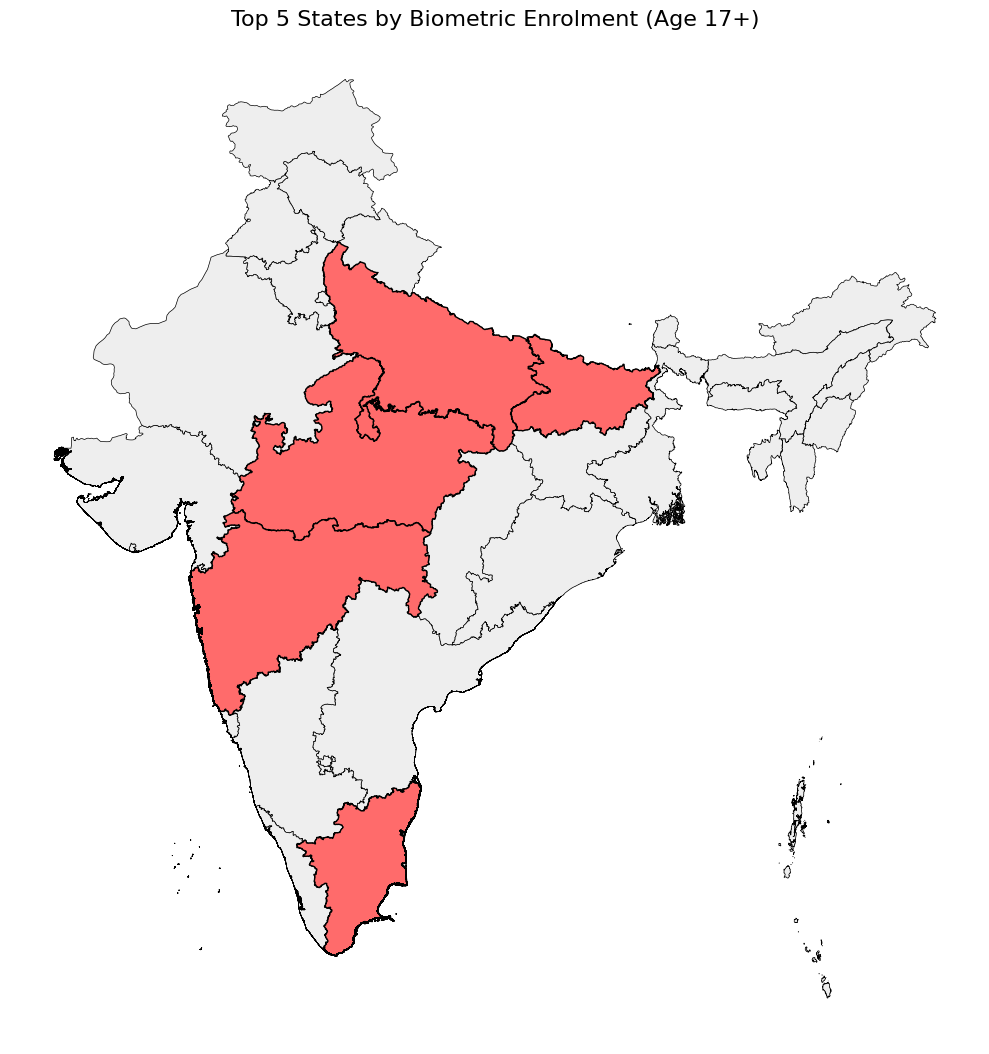

In [38]:
fig, ax = plt.subplots(figsize=(10, 12))

# Plot all states in light grey
india_states.plot(
    ax=ax,
    color="#eeeeee",
    edgecolor="black",
    linewidth=0.5
)

# Highlight top 5 states
top_states_geo_18_.plot(
    ax=ax,
    color="#ff6b6b",
    edgecolor="black",
    linewidth=1
)

ax.set_title("Top 5 States by Biometric Enrolment (Age 17+)", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.show()


# Uttar Pradesh Biometric Status 18+

In [40]:
top_districts_18_ = (
    up_df
    .groupby("district", as_index=False)["bio_age_17_greater"]
    .sum()
    .sort_values("bio_age_17_greater", ascending=False)
)

top_districts_18_

,district,bio_age_17_greater
32,Gorakhpur,97125.0
48,Lucknow,93889.0
42,Kanpur Nagar,89037.0
29,Ghaziabad,88909.0
0,Agra,83332.0
...,...,...
6,Ayodhya,3783.0
13,Barabanki,3457.0
16,Bhadohi,2928.0
61,Raebareli,6.0


In [41]:
def normalize_district(s):
    return (
        s.lower()
        .replace("&", "and")
        .replace(".", "")
        .replace(" district", "")
        .strip()
    )

up_districts_gdf["district_norm"] = (
    up_districts_gdf["NAME_2"].apply(normalize_district)
)

top_districts_18_["district_norm"] = (
    top_districts_18_["district"].apply(normalize_district)
)

In [42]:
gdf = up_districts_gdf.merge(
    top_districts_18_,
    on="district_norm",
    how="left"
)

# Replace NaN enrolment with 0
gdf["bio_age_17_greater"] = gdf["bio_age_17_greater"].fillna(0)


In [46]:
top5_18 = (
    gdf[["NAME_2", "bio_age_17_greater"]]
    .sort_values("bio_age_17_greater", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

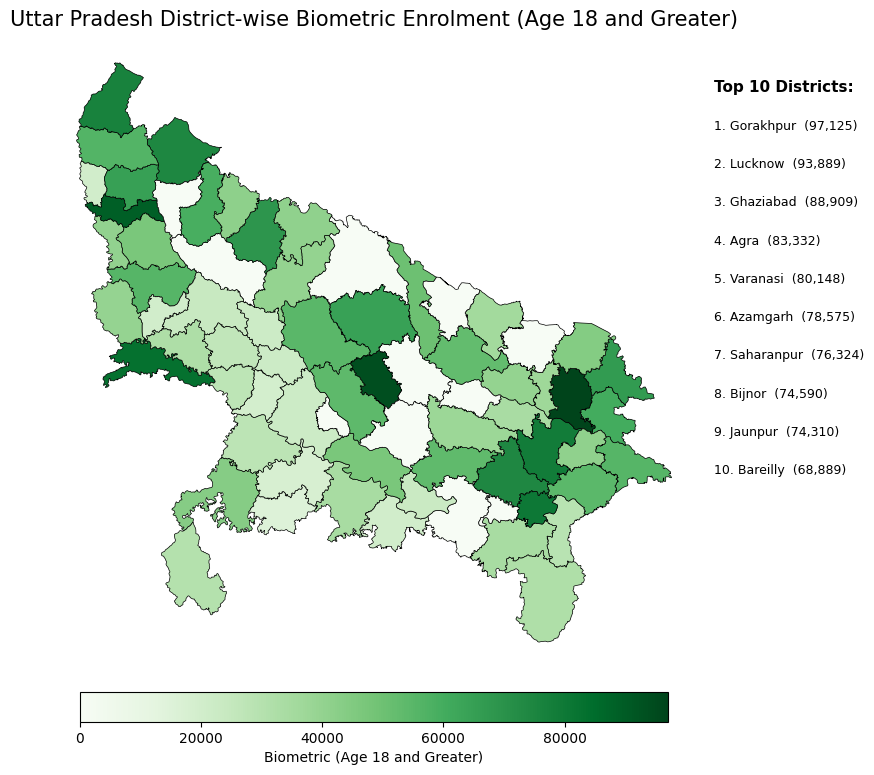

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

gdf.plot(
    ax=ax,
    column="bio_age_17_greater",
    cmap="Greens",          # light → dark
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
    "label": "Biometric (Age 18 and Greater)",
    "orientation": "horizontal",
    "shrink": 0.9,
    "pad": 0.02
}
)

ax.set_title(
    "Uttar Pradesh District-wise Biometric Enrolment (Age 18 and Greater)",
    fontsize=15
)
ax.axis("off")
x_pos = 1.02   # right of the map
y_start = 0.85
line_gap = 0.06

ax.text(
    x_pos, y_start + line_gap,
    "Top 10 Districts:",
    transform=ax.transAxes,
    fontsize=11,
    fontweight="bold",
    ha="left"
)

for i, row in top5_18.iterrows():
    ax.text(
        x_pos,
        y_start - i * line_gap,
        f"{i+1}. {row['NAME_2']}  ({int(row['bio_age_17_greater']):,})",
        transform=ax.transAxes,
        fontsize=9,
        ha="left"
    )
plt.tight_layout(rect=[0, 0.08,0.85, 1])

plt.show()


In [52]:
gorakhpur_df = final_df[
    (final_df["state"] == "Uttar Pradesh") &
    (final_df["district"] == "Gorakhpur")
].copy()


In [55]:
import pandas as pd

gorakhpur_df["bio_age_17_greater"] = pd.to_numeric(
    gorakhpur_df["bio_age_17_greater"], errors="coerce"
).fillna(0)

pincode_enrol = (
    gorakhpur_df
    .groupby("pincode", as_index=False)["bio_age_17_greater"]
    .sum()
)

# Ensure string for merge
pincode_enrol["pincode"] = pincode_enrol["pincode"].astype(str)

pincode_enrol


,pincode,bio_age_17_greater
0,273001,5004.0
1,273002,2091.0
2,273003,449.0
3,273004,1005.0
4,273005,1816.0
5,273006,456.0
6,273007,3774.0
7,273008,2252.0
8,273009,35.0
9,273010,1307.0


In [56]:
pin_code_gdf = gpd.read_file("../Dataset/GeoJSON/india_pincode.geojson")

In [57]:
# Ensure pincode column consistency
pin_code_gdf["Pincode"] = pin_code_gdf["Pincode"].astype(str).str.strip()

gorakhpur_df = pin_code_gdf.merge(
    pincode_enrol,
    left_on="Pincode",
    right_on="pincode",
    how="inner"
)


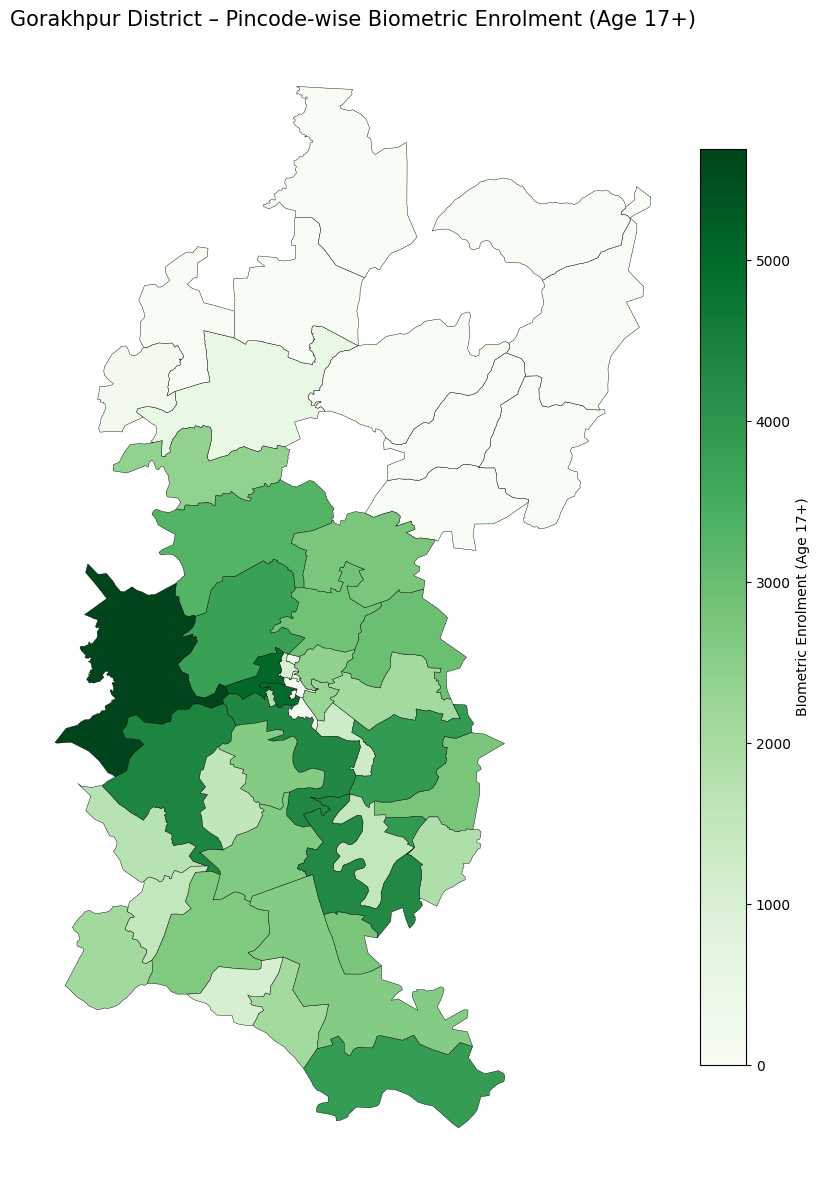

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

gorakhpur_df.plot(
    ax=ax,
    column="bio_age_17_greater",
    cmap="Greens",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "BIometric Enrolment (Age 17+)",
        "shrink": 0.8,
        "pad": 0.02
    }
)

ax.set_title(
    "Gorakhpur District – Pincode-wise Biometric Enrolment (Age 17+)",
    fontsize=15
)
ax.axis("off")

plt.tight_layout()
plt.show()
